In [1]:
import matplotlib.pyplot as plt
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np
## division for train and test
from sklearn.model_selection import train_test_split
##
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
#import sys
#!{sys.executable} -m pip install --upgrade https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-1.8.0-cp36-cp36m-linux_x86_64.whl --user
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D ,Convolution2D, MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.optimizers import SGD
from keras.utils import np_utils

/home/tlc/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
## Return a zero np.array with the only one in index position and with length given
def labelCreator (index, dim):
    try:
        a = np.zeros(dim, dtype = 'int')
        a [:,index] = 1
        return a
    except:
        return -1

def xyCreator(dic):
    X = []
    Y = []
    if type(dic)==dict:
        length = len(dic)
        for count, key in enumerate(dic):
            tmp = dic[key]
            label = np.array(count)
            label = np.resize(label, (tmp.shape[0],1))
            #label = labelCreator(count, [tmp.shape[0], length])
            X.append(tmp)
            Y.append(label)
            print(key, ' ', count)
    else:
        return -1
    return np.vstack(X) , np.vstack(Y)  

def plotConfusionMatrix(predictions, true_labels, labels):
    k = true_labels.shape[1]
    n = true_labels.shape[0]
    confusion_matrix = np.zeros((k,k))

    for l in range(n):
        decision = np.zeros(k)
        j = np.argmax(predictions[l])
        decision[j] = 1
        i = np.argmax(true_labels[l])
        confusion_matrix[i,j] +=1
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [3]:
#with open('variables/rawDict.pkl', 'rb') as f:  
    #rawDict = pickle.load(f)
with open('variables/noiseDict.pkl', 'rb') as f:  
    noiseDict = pickle.load(f)    
with open('variables/mfccDict.pkl', 'rb') as f:  
    mfccDict = pickle.load(f)
with open('variables/fbankDict.pkl', 'rb') as f:  
    fbankDict = pickle.load(f)    
    
coreKey = ["Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero",
           "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]


In [13]:
toFit = {'one', 'two', 'three'}#,'four','five','six','seven','eight','nine'}
X , Y = xyCreator({k: mfccDict[k] for k in mfccDict.keys() & toFit})
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
y_train = np_utils.to_categorical(y_train, np.max(Y)+1)
y_test = np_utils.to_categorical(y_test, np.max(Y)+1)
X_train_r = np.reshape(X_train, ( X_train.shape[0],1, X_train.shape[1], X_train.shape[2]))
X_test_r = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))


three   0
one   1
two   2


In [8]:
cnn = Sequential()

cnn.add(Convolution2D(128, (5,4),  strides = (1,1), padding="valid",  activation="relu",
                      input_shape=(1, X_train.shape[1], X_train.shape[2])))

cnn.add(MaxPooling2D(pool_size=(3,2)))

cnn.add(Convolution2D(64, (3,2),  strides = (1,1), padding="valid", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
      
cnn.add(Flatten())

cnn.add(Dense(100, activation="relu"))
cnn.add(Dropout(0.65))

cnn.add(Dense(40, activation="relu"))
cnn.add(Dropout(0.35))

cnn.add(Dense(y_train.shape[1], activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 95, 10)       2688      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 31, 5)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 29, 4)         49216     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 14, 2)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               179300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [9]:
nb_epoch = 20
cnn.fit(X_train_r, y_train, epochs=nb_epoch, validation_data=(X_test_r, y_test), batch_size=64)

Train on 5679 samples, validate on 1420 samples
Epoch 1/20
5679/5679 [==============================] - 40s 7ms/step - loss: 1.1394 - acc: 0.4721 - val_loss: 0.5806 - val_acc: 0.7817
Epoch 2/20
5679/5679 [==============================] - 39s 7ms/step - loss: 0.5254 - acc: 0.7912 - val_loss: 0.2220 - val_acc: 0.9324
Epoch 3/20
 320/5679 [>.............................] - ETA: 32s - loss: 0.4157 - acc: 0.8531

KeyboardInterrupt: 

In [ ]:
cnn.evaluate(X_test_r,y_test)

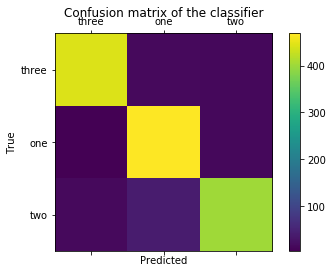

In [15]:
preds = cnn.predict(X_test_r)
plotConfusionMatrix(preds,y_test,list(toFit))